In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from datetime import datetime
import time

In [53]:
df = pd.read_csv('bioresponse.csv')
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X = df.drop(['Activity'], axis=1)
y = df['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)
X_train = np.asarray(X_train).T
X_test = np.asarray(X_test).T
y_train = np.asarray(y_train).T
y_test = np.asarray(y_test).T

In [409]:
class AdamOptim():
    def __init__(self, eta=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m_dw, self.v_dw = 0, 0
        self.m_db, self.v_db = 0, 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self, t, w, b, dw, db):
        self.m_dw = self.beta1 * self.m_dw + (1.-self.beta1) * dw
        self.m_db = self.beta1 * self.m_db + (1.-self.beta1) * db

        self.v_dw = self.beta2 * self.v_dw + (1.-self.beta2) * (dw*dw)
        self.v_db = self.beta2 * self.v_db + (1.-self.beta2) * (db*db)

        ## bias correction
        m_dw_corr = self.m_dw / (1. - np.power(self.beta1, t))
        m_db_corr = self.m_db / (1. - np.power(self.beta1, t))
        v_dw_corr = self.v_dw / (1. - np.power(self.beta2, t))
        v_db_corr = self.v_db / (1. - np.power(self.beta2, t))

        ## update weights and biases
        w = w - self.eta * (m_dw_corr/(np.sqrt(v_dw_corr) + self.epsilon))
        b = b - self.eta * (m_db_corr/(np.sqrt(v_db_corr) + self.epsilon))
        return w, b

In [382]:
# sigmoid
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1./(1.+np.exp(-z))
    
    return s

# initialize_with_zeros
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

In [416]:
# propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size which equals the number of features
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost


# optimize
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False, SGD=False, batch_size=None):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    
    for i in range(num_iterations):
        if SGD == True:
            # pick a random sample of data
            # I'm getting 5% of data for SGD
            #_, X_sample, __, Y_sample = train_test_split(X.T, Y, test_size=batch_size)
            idxs = np.random.randint(X.shape[1], size=batch_size)
            X_sample = []
            Y_sample = []
            for idx in idxs:
                X_sample.append(X.T[idx])
                Y_sample.append(Y[idx])
            
            X_sample = np.array(X_sample)
            Y_sample = np.array(Y_sample)
            grads, cost = propagate(w, b, X_sample.T, Y_sample)
            
        else:    
            # Cost and gradient calculation 
            grads, cost = propagate(w,b,X,Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record ALL the costs
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs


def optimize_adam(w, b, X, Y, num_iterations, learning_rate, print_cost=False, SGD=False, batch_size=None):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    Y -- true "label" vector (containing 0 and 1), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    adam = AdamOptim()
    
    for i in range(1, num_iterations):
    
        if SGD == True:
            # get a random sample of data with a size of batch_size
            idxs = np.random.randint(X.shape[1], size=batch_size)
            X_sample = []
            Y_sample = []
            for idx in idxs:
                X_sample.append(X.T[idx])
                Y_sample.append(Y[idx])
            
            X_sample = np.array(X_sample)
            Y_sample = np.array(Y_sample)
            grads, cost = propagate(w, b, X_sample.T, Y_sample)
            
        else:    
            # Cost and gradient calculation 
            grads, cost = propagate(w, b, X, Y)
                
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        w, b = adam.update(i, w=w, b=b, dw=dw, db=db)
    
        # Record ALL the costs
        costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

# predict
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array 
    b -- bias, a scalar
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities 
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1
    
    return Y_prediction


# model
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False, SGD=False, batch_size=None, adam=False):
    """
    Builds the logistic regression model by calling the function we've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array 
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array 
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros 
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent and calculate time of optimize function
    if adam == False:
        start_time = datetime.now()
        parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost, SGD, batch_size)
        time = datetime.now() - start_time
    else:
        start_time = datetime.now()
        parameters, grads, costs = optimize_adam(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost, SGD, batch_size)
        time = datetime.now() - start_time
        
        
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors and Final Loss
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    print("final loss: {}".format(costs[-1]))
    print("execution time: {}".format(time))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations" : num_iterations,
         "SGD" : SGD
        }
    
    return d

train accuracy: 79.77248489157483 %
test accuracy: 74.6268656716418 %
final loss: [0.44653863]
execution time: 0:00:00.694087


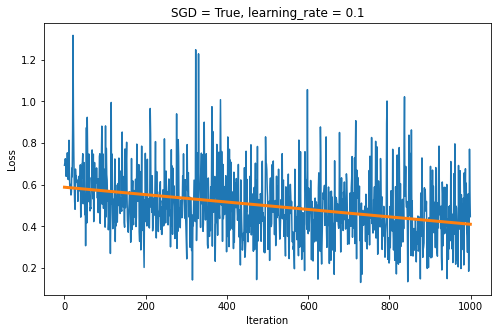

train accuracy: 80.02132954141486 %
test accuracy: 76.01279317697228 %
final loss: [0.7338021]
execution time: 0:00:00.810638


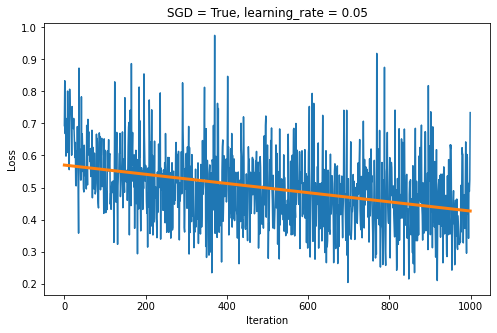

train accuracy: 76.64415215072876 %
test accuracy: 72.49466950959489 %
final loss: [0.41835234]
execution time: 0:00:00.814492


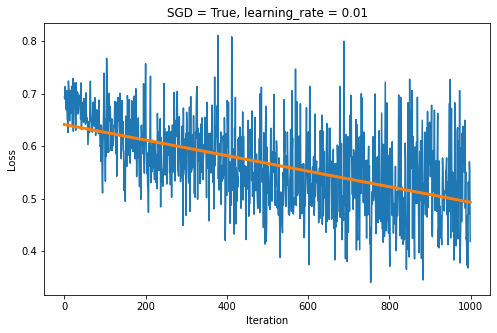

train accuracy: 75.57767507998578 %
test accuracy: 72.28144989339019 %
final loss: [0.45730364]
execution time: 0:00:00.714883


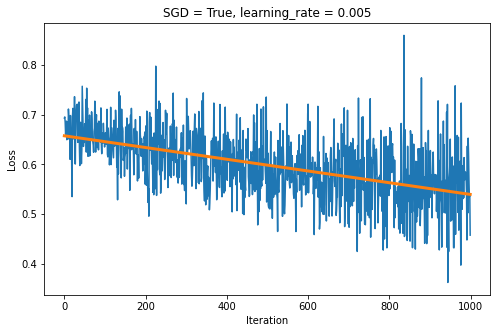

train accuracy: 67.25915392819054 %
test accuracy: 65.88486140724947 %
final loss: [0.60714558]
execution time: 0:00:00.786207


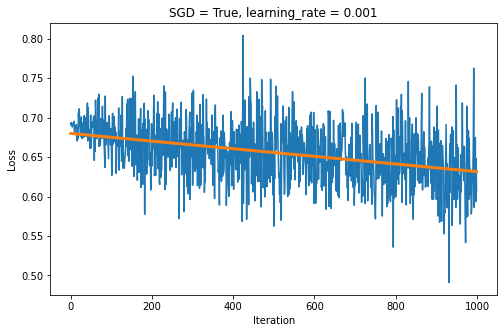

train accuracy: 81.90543903306079 %
test accuracy: 77.29211087420043 %
final loss: [0.40802161]
execution time: 0:00:07.215516


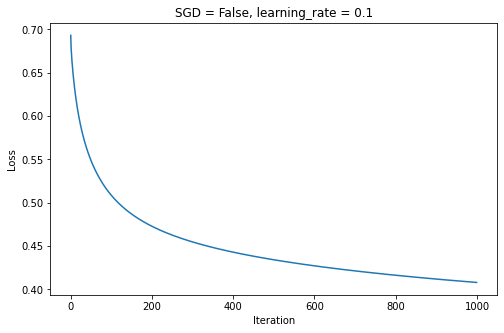

train accuracy: 80.59011731247779 %
test accuracy: 76.54584221748401 %
final loss: [0.43422365]
execution time: 0:00:07.234743


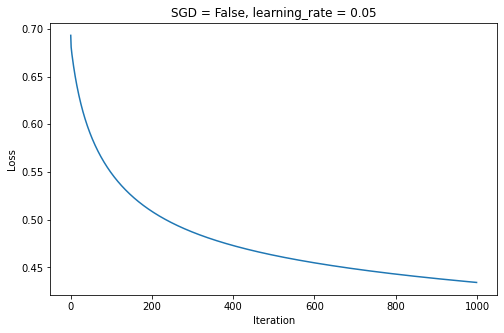

train accuracy: 77.03519374333452 %
test accuracy: 75.05330490405117 %
final loss: [0.50876162]
execution time: 0:00:06.836555


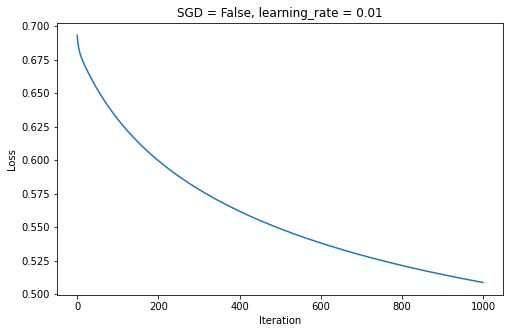

train accuracy: 75.25773195876289 %
test accuracy: 73.77398720682302 %
final loss: [0.54894724]
execution time: 0:00:07.970251


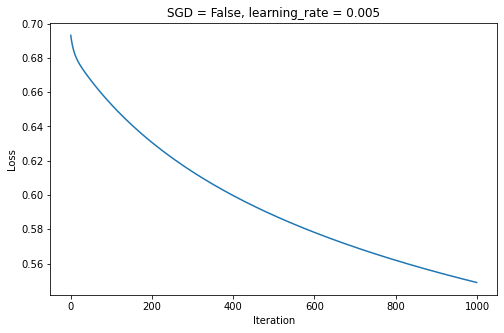

train accuracy: 67.18805545680767 %
test accuracy: 65.56503198294243 %
final loss: [0.63068129]
execution time: 0:00:07.038800


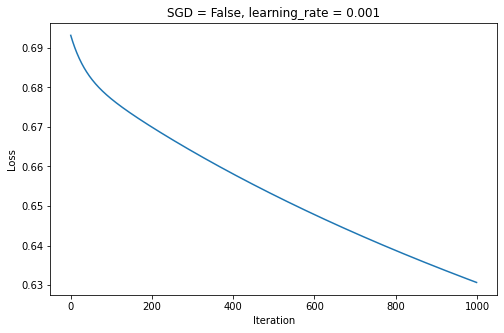

In [417]:
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
grad_types = [True, False]

for sgd, lr in list(itertools.product(grad_types, learning_rates)):   
    gd = model(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=lr, print_cost=False, SGD=sgd, batch_size=15)

    plt.figure(figsize=(8,5))
    plt.plot(gd['costs'])
    
    if sgd == True:
        # linear regression model was trained to see the general behavior of loss function
        # we can see the downtrend, so loss value decreases while iteration number increases
        from sklearn.linear_model import LinearRegression
        regr = LinearRegression()
        regr.fit(np.arange(1000).reshape(-1,1), gd['costs'])
        linear_regr_val = [regr.coef_[0] * x + regr.intercept_ for x in range(1000)]
        plt.plot(linear_regr_val, linewidth=3)
        
    title = "SGD = " + str(gd['SGD']) + ", learning_rate = " + str(gd['learning_rate'])
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

As we see, loss converges better when learning_rate is equal to 0.1. Loss is becoming worse with increasing of learning_rate. But maybe if we do more iterations, some other learning rate would be better. Stochastic Gradient Descent slightly worse converges, but amount of time for gradient calculations decreased by almost 10 times. Butch size was 15.

In [413]:
gd1 = model(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=0.01, print_cost=False, SGD=False, adam=False)
gd2 = model(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=0.01, print_cost=False, SGD=False, adam=True)
gd3 = model(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=0.01, print_cost=False, SGD=True, batch_size=15, adam=False)
gd4 = model(X_train, y_train, X_test, y_test, num_iterations=1000, learning_rate=0.01, print_cost=False, SGD=True, batch_size=15, adam=True)

train accuracy: 77.03519374333452 %
test accuracy: 75.05330490405117 %
final loss: [0.50926764]
execution time: 0:00:07.339234


C:\Users\4CFA~1\AppData\Local\Temp/ipykernel_8536/3225439640.py:22: RuntimeWarning: divide by zero encountered in log
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost
C:\Users\4CFA~1\AppData\Local\Temp/ipykernel_8536/3225439640.py:22: RuntimeWarning: invalid value encountered in multiply
  cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost


train accuracy: 91.85922502666193 %
test accuracy: 74.94669509594883 %
final loss: [0.21859429]
execution time: 0:00:07.678004
train accuracy: 76.46640597227159 %
test accuracy: 73.66737739872069 %
final loss: [0.50391749]
execution time: 0:00:00.715829
train accuracy: 82.97191610380378 %
test accuracy: 76.43923240938166 %
final loss: [0.1868976]
execution time: 0:00:00.809327


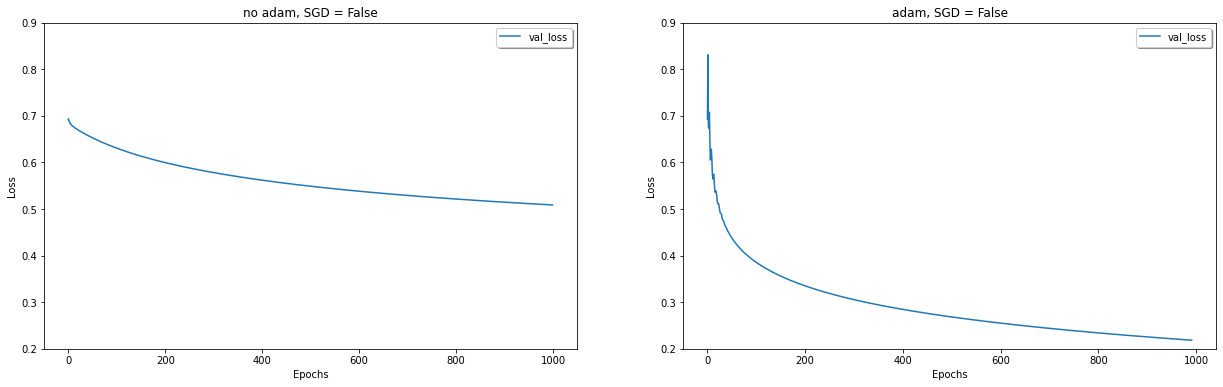

In [414]:
optimizers = ['no adam', 'adam']
fig, axs = plt.subplots(1, 2, figsize = (21, 6))
for i, h in enumerate([gd1['costs'], gd2['costs']]):
    axs[i].set_ylim(0.2, 0.9)
    #axs[i].set_xlim(0, 100)
    axs[i].plot(h, label='val_loss')
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].set_title(optimizers[i] + ", SGD = False")
    axs[i].legend(shadow=True, loc=1)

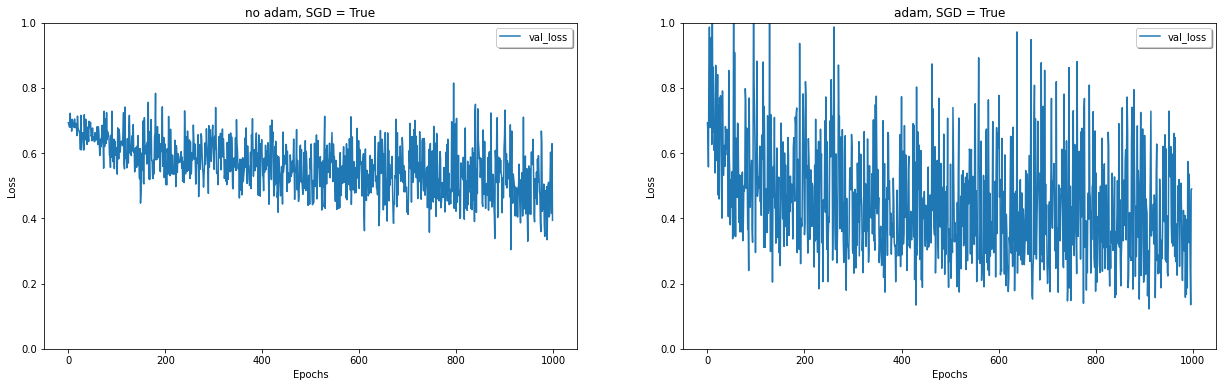

In [415]:
optimizers = ['no adam', 'adam']
fig, axs = plt.subplots(1, 2, figsize = (21, 6))
for i, h in enumerate([gd3['costs'], gd4['costs']]):
    axs[i].set_ylim(0, 1)
    #axs[i].set_xlim(0, 100)
    axs[i].plot(h, label='val_loss')
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Loss")
    axs[i].set_title(optimizers[i] + ", SGD = True")
    axs[i].legend(shadow=True, loc=1)

We clearly can see that ADAM optimization converges faster than usual SGD or GD.